# **Solution**

---


## **PREPARE Challenge - Phase 3**

# **Summary**

---





### This Notebook Covers:
✅ **Component 0. Setup Environment**: Install dependencies, load SpeachCARE model checkpoints & configure paths

✅ **Component 1.  Model Initialization & Data Preprocessing**: Initializing the SpeachCARE model with the trained checkpoint; preprocessing audio data. To run this step the path to the speaker's audio file and age must be specified if you want to use your own data.

✅ **Component 2: Saliency Visualization on the Waveform (NEW In Phase 3)**:
This visualization highlights important segments of the audio waveform to the SpeechCARE model using saliency mapping. The highlighted waveform segments represent distinctive regions that may contain key vocal features.

✅ **Component 3: Spectrogram Visualization & Acoustic Feature Analysis (Improved In Phase 3)**: This visualization includes SHAP augmented spectrogram; plotting Fundamental Frequency [F0] on the spectrogram; plotting pauses on the spectrogram.

✅ **Component 4: Visualization of the Speaker's Rhythmic Structure by Shannon Entropy (Improved In Phase 3)**: This analysis identifies rhythmic patterns in the audio sample by measuring entropy fluctuations over time. Segments with low entropy (highlighted in red) suggest monotonous or less rhythmically dynamic speech.

✅ **Component 5: Acoustic Feature Analysis with Quartile Categorizationm**:
This analysis compares the given audio sample against reference distributions of key acoustic features (Shimmer standard deviation, energy of frequency domain, Fundamental Frequency [F0] standard deviation, and Third Formant Frequency [F3] standard deviation) in the reference dataset.


✅ **Component 6.  Interpretation**: For the computed acoustic features (pauses, rhythmic structure, shimmer, energy of frequency domain, f0 & f3), we provide a human-understandable interpretation, highlighting the cognitive status of the speaker.





# **Hardware**

---

**Hardware Requirements**
*  A minimum of one NVIDIA® T4 GPU with 16 GB of VRAM is required.

**Training Time**
*  No training is needed; you only need to load the model checkpoint.

**Inference Time**
*  If you have the SpeechCARE model checkpoint, the inference time would be less than 1 minute for each audio sample.


# **Component 0. Setup Environment**

---

**Install the required python packages**

This cell installs all Python packages listed in `requirements.txt`. The file contains all necessary dependencies.

- Run this cell only once at the beginning of your session

- If you encounter errors, you may need to restart the runtime after installation


In [ ]:
!git clone https://github.com/SpeechCARE/SpeechCARE_Explainability_Framework.git

In [1]:
import sys
sys.path.append('/SpeechCARE_Explainability_Framework')

In [ ]:
%cd SpeechCARE_Explainability_Framework

In [ ]:
!pip install --upgrade pip
!pip uninstall xformers -y
!pip install -r requirements.txt
!apt update && apt install ffmpeg -y

**Import Necessary Libraries**

This cell imports all required Python libraries and modules. The imports are organized by functionality for better understanding.

In [ ]:
# Model and weights management
from model.WeightsManager import WeightManager
from model.ModelWrapper import ModelWrapper

from utils.Config import Config
from utils.Utils import load_yaml_file
from utils.dataset_utils import preprocess_data,peak_normalization

from acoustic_module.utils import detect_pauses_from_audio
from acoustic_module.FeatureExtraction import analyze_column_single, get_audio_files
from acoustic_module.interpretation_report import generate_vocal_analysis_report,vocal_analysis_interpretation_report
from acoustic_module.EntropyAnalyzer import EntropyAnalyzer
from explainability.SHAP.AcousticShap import AcousticShap
from explainability.plotting.explainability_plotting import plot_colored_waveform
from explainability.Gradient_based.saliency_map import compute_saliency_waveform


# Data processing and visualization
import pandas as pd
import yaml
import torch
from IPython.display import Image, display, Markdown, HTML
import os

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

**Download Model Checkpoint**

Downloade-trained modecheckpointts from Google Drive using the WeightManager class.


**Configuration Options:**

- `file_id`: Replace with your own Google Drive file ID

- `output_name`: Change to save weights with a different filename

In [ ]:
# Initialize the weight manager
weight_manager = WeightManager()

try:
    # Download model checkpoint from Google Drive
    weight_path = weight_manager.download_weights(
        file_id="1-SLBGZRoNGRPHBtWJUDR8WCFpFiVYJM4",  # Google Drive file ID
        output_name="model.pt",                       # Name for downloaded file
    )
    print(f"Success: Weights saved to {weight_path}")

except Exception as e:
    print(f"Error downloading weights: {e}")
    print("Please check:")
    print("- Your internet connection")
    print("- The file ID is correct")
    print("- Google Drive permissions")

**Load and Display Configurations**

Loads and displays configuration file that control model behavior.

In [ ]:
# Display model configuration
display(Markdown("### Model Configuration"))
with open("data/model_config.yaml") as f:
    model_config = yaml.safe_load(f)
    display(model_config)

# Display pause detection configuration
display(Markdown("### Pause Detection Configuration"))
with open("data/pause_config.yaml") as f:
    pause_config = yaml.safe_load(f)
    display(pause_config)

# Initialize config objects for the application
config = Config(load_yaml_file("data/model_config.yaml"))
config_pause = Config(load_yaml_file("data/pause_config.yaml"))

# **Component 1: Model Initialization & Data Preprocessing**
---

### **Model Intialization:**
The SpeechCARE model with trained checkpoint is loaded here.


**Key Components:**

- `ModelWrapper`: Handles model architecture

- `config`: Contains model parameters

- `weight_path`: Location of trained SpeechCARE model checkpoint

In [ ]:
# Initialize model wrapper with configuration
wrapper = ModelWrapper(config)

# Load trained weights into the model
model = wrapper.get_model(weight_path)
model.eval()

print("Model successfully initialized with weights from:", weight_path)

### **Data Preprocessing:**

Prepares a specific audio sample by denoising the audio, providing its transcription and age category. You should provide:

- `AUDIO_PATH`: Full path to the audio file, WAV format recommended (required for an individual sample) .
- `AGE`: Age of the speaker as an integer value (required for an individual sample).

In [9]:
AUDIO_PATH = f"data/qnvo.mp3"  # Path to the input audio file (update it with your desired audio file path)
AGE = 72  # Age of the speaker

In [ ]:
# Process audio sample and corresponding age
# Arguments:
#   audio_path: Path to input audio file
#   age: Speaker's age
#   output_dir: Directory to store processed audio file


processed_audio_path, demography_info, transcription = preprocess_data(audio_path=AUDIO_PATH, age=AGE,apply_lowpass = True, output_dir='../processed_audio')
peak_norm_audio_path = peak_normalization(audio_path=AUDIO_PATH)

# Convert age (by default: int) to tensor
# Reshaped it to (1, 1) for batch processing compatibility
demography_tensor = torch.tensor(demography_info, dtype=torch.float16).reshape(1, 1)

# --- Word-Level Analysis Setup ---
# Print analysis information for verification
print(f"Analyzing sample: {processed_audio_path}")
print(f"Speaker age category: {demography_info}")


# **Component 2: Saliency Visualization on the Waveform (NEW In Phase 3)**
---

This visualization highlights important segments of the audio waveform to the SpeechCARE model using saliency mapping. The highlighted waveform segments represent distinctive regions that may contain key vocal features.

#### Generating Input Values to the Model


In [ ]:
input_values,_,_,_ = model.preprocess_data(peak_norm_audio_path,segment_length=model.config.segment_size,demography_info=demography_info)

#### Computing Saliency Data


In [15]:
saliency_data = compute_saliency_waveform(model=model,input_segments=input_values,audio_path=peak_norm_audio_path,segment_length=model.config.segment_size)

#### Visualizing Saliency Map on the Waveform


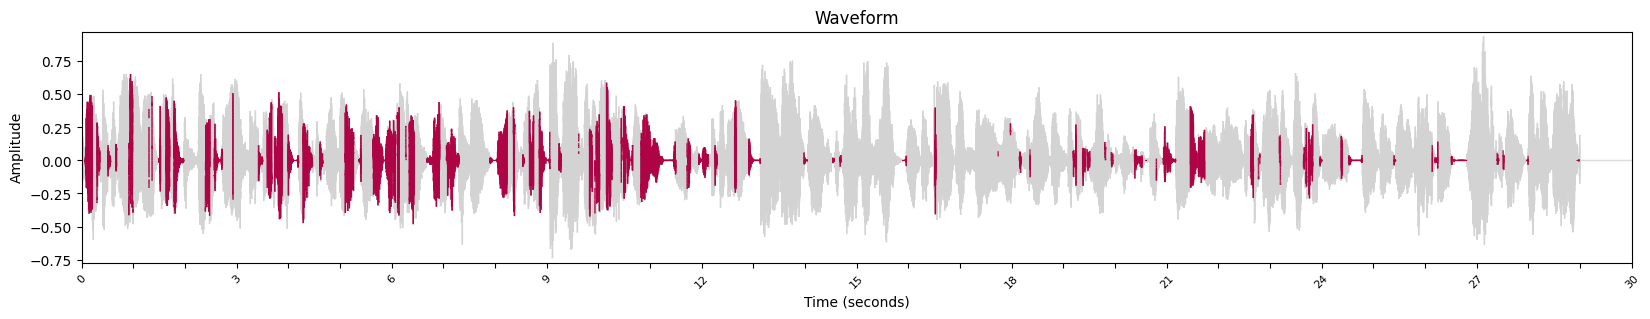

In [16]:
plot_colored_waveform(
    total_duration=saliency_data['time'][-1],
    saliency_data=saliency_data,
    figsize = (20, 3),
    include_title=True
)

# **Component 3: Spectrogram Visualization & Acoustic Feature Analysis**
---
Visualizing SHAP augmented spectrogram; plotting Fundamental Frequency [F0] on the spectrogram; plotting pauses on the spectrogram.

#### Initalize the acoustic explainer class


In [17]:
acoustic_explainer = AcousticShap(model)
print("Acoustic explainer ready for analysis")

Acoustic explainer ready for analysis


## **Original Spectrogram Visualization**

Generates and displays the original log-mel spectrogram of the sample.

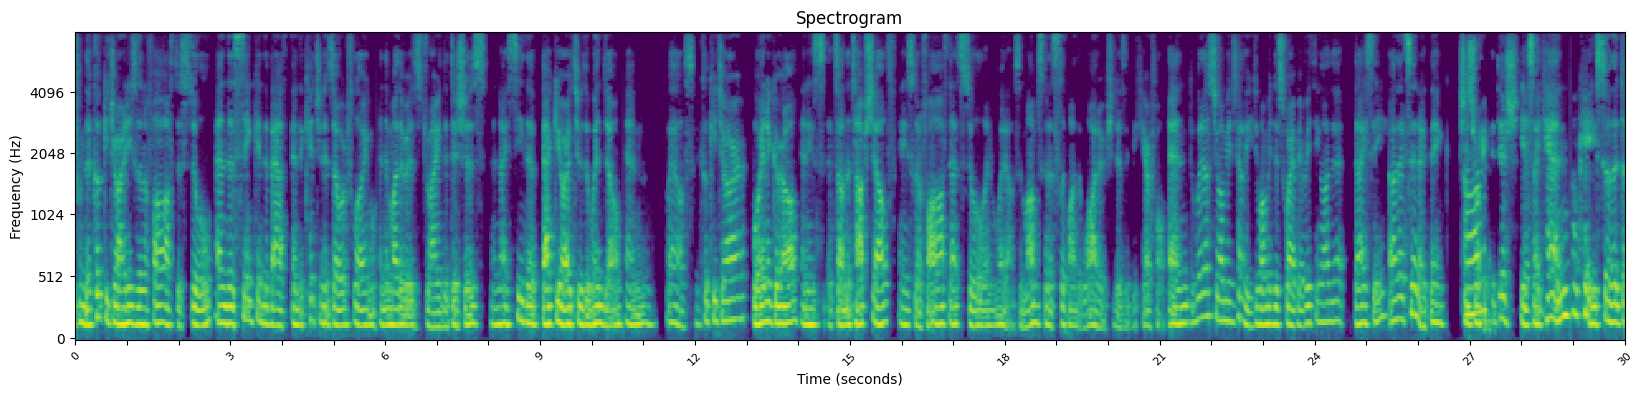

In [18]:
# Create and display original spectrogram
acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    sr=16000,
    spectrogram_type="original",
    pauses=None,  # Can add pause markers if available
    plot=True,  # Set to False to suppress display,
    figsize=(20,4)
)

## **Step 1. SHAP-Augmented Spectrogram Visualization (IMPROVED In Phase 3)**

* SHAP Analysis: SHAP was used to assess the impact of each specified segment on predictions by applying masking and computing SHAP values.

* Spectrogram Visualization: SHAP values were mapped onto Log-Mel spectrograms, with segment opacity adjusted to highlight informative vocal cues.

Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can.
Tokenizing transcription...
Preprocessing audio...


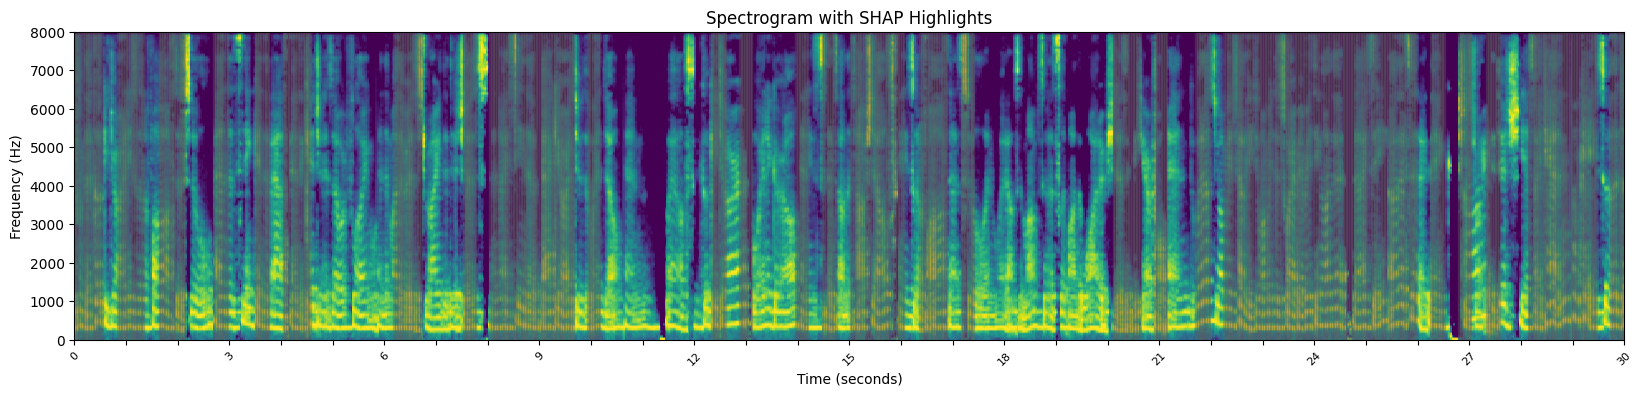

In [19]:
# Generate and visualize the SHAP spectrogram
acoustic_explainer.get_speech_spectrogram(processed_audio_path, demography_tensor, config,sr=16000,spectrogram_type = 'shap', plot=True, figsize=(20,4))


## **Step 2. Visualization of Informative Puases on Spectrogram**


- Detect pauses
    - Identify informative pauses (pauses before nouns) by analyzing the part-of-speech (POS) tags of surrounding words. In this report, we have improved our previous method by additionally marking pauses near conjunctions and uncertainty words as they are informative.
    - Highlight the pauses on the spectrogram


**Key Parameters:**

- `energy_threshold`: Lower values detect more subtle pauses

- `min_pause_duration`: Adjust to ignore very short pauses

- `expansion_threshold`: Boundary expansion threshold for refining pauses
- `marked=True`: Highlights linguistically informative pauses

- `refined=True`: Extra refinement to make pauses more accurate





In [ ]:
pauses = detect_pauses_from_audio(config=config_pause,
        audio_path=processed_audio_path,
        sr=48000,
        energy_threshold=0.001,
        min_pause_duration=0.1,
        expansion_threshold=0.03,
        marked=True,  # Mark important pauses
        refined=True  # Use refined boundaries

    )
print(f"Detected {len(pauses)} pauses in audio sample")

Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can.
Tokenizing transcription...
Preprocessing audio...


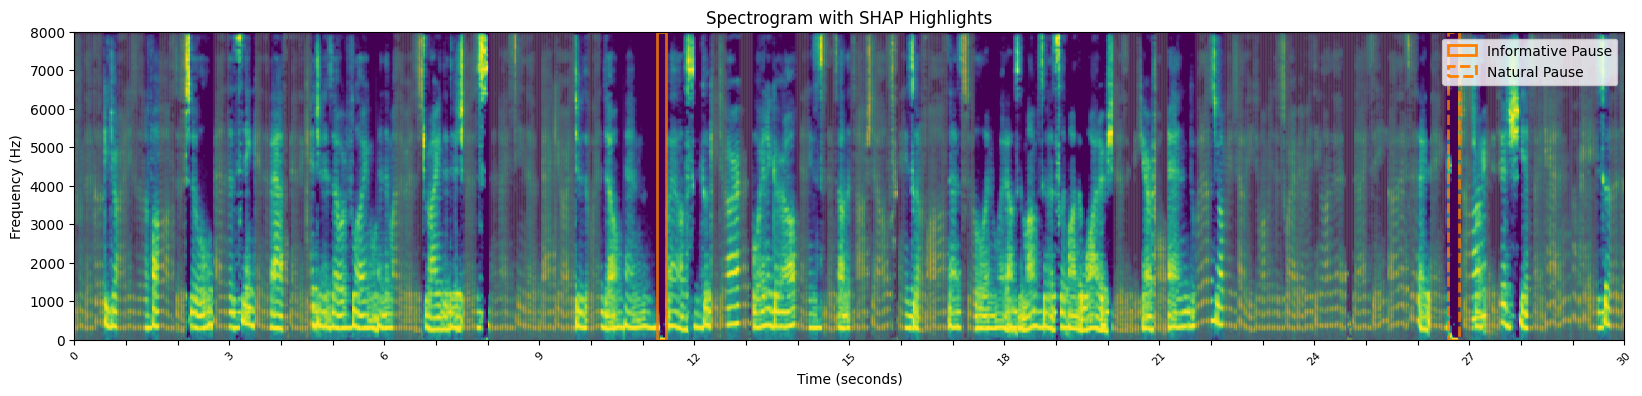

In [21]:
# Visualize with marked pauses
acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    spectrogram_type='shap',
    pauses=pauses,  # Pass detected pauses
    formants_to_plot=[],
    plot=True,
    figsize=(20,4)
)

## **Step 3. Visualization of Fundamental Frequency (F0) on Spectrogram**

Fundamental Frequency (F0) is the lowest frequency of a periodic sound wave (like voiced speech).

Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can.
Tokenizing transcription...
Preprocessing audio...


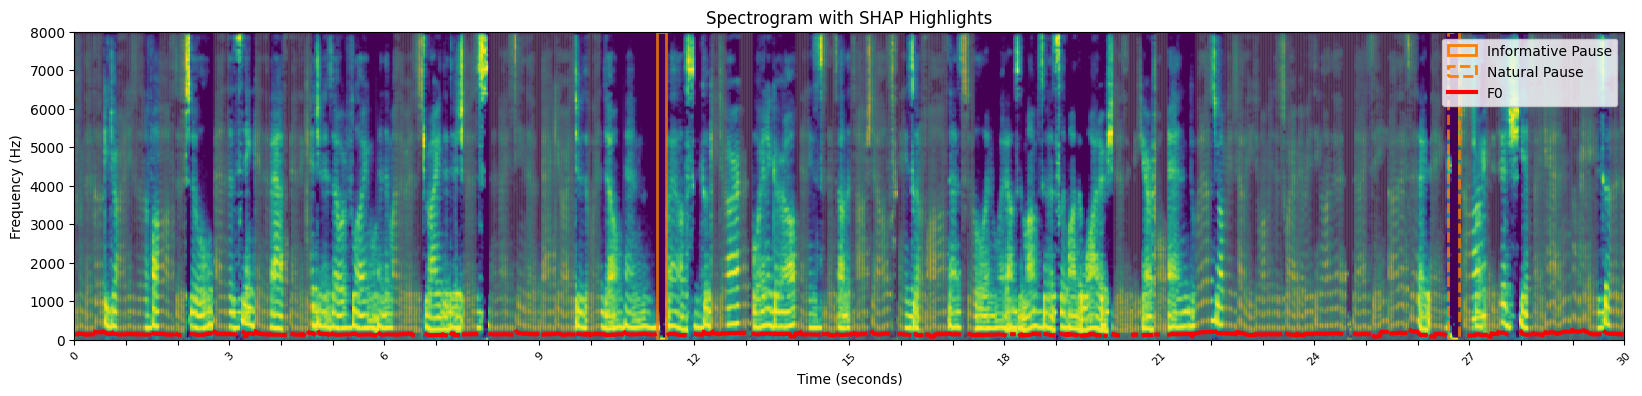

In [22]:
# Visualize with F0
acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    spectrogram_type='shap',
    pauses=pauses,
    formants_to_plot=['F0'], #Options: Formant Frequencies (F1, F2, F3, ...)
    plot=True,
    figsize=(20,4)
)

# **Component 4: Visualization of the Speaker's Rhythmic Structure by Shannon Entropy (IMPROVED In Phase 3)**
---

This analysis identifies rhythmic patterns in the audio sample by measuring entropy fluctuations over time. Segments with low entropy (highlighted in red) suggests monotonous or less rhythmically dynamic speech.

#### Initalize the acoustic explainer class


In [23]:
entropy_analyzer = EntropyAnalyzer()

#### Computing Entropy Data & Visualizing Normalized Shannon Entropy

**Key Parameters:**

- `window_size`:  Analysis window length

- `min_duration`: Minimum valid segment duration

- `segments_merge_gap`: Max gap between segments to merge
- `segments_std_threshold`: Entropy fluctuation threshold

- `flucturation_frame_size`: Local dynamic change resolution

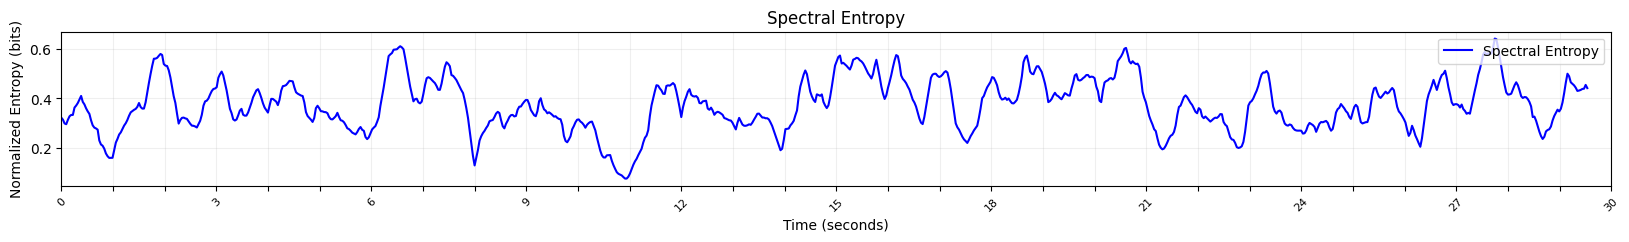

In [24]:
entropy_data = entropy_analyzer.analyze(processed_audio_path,window_size=15,min_duration=5,segments_merge_gap=.1,segments_std_threshold=0.075,flucturation_frame_size=17, visualize=True,figsize=(20,2))

# **Component 5: Acoustic Feature Analysis with Quartile Categorization**
---
This analysis compares the given audio sample against reference distributions of key acoustic features (Shimmer standard deviation, energy of frequency domain, Fundamental Frequency [F0] standard deviation, and Third Formant Frequency [F3] standard deviation) in the reference dataset.



### **Reference Dataset**

> The reference dataset provides values for key acoustic features, computed from all audio recordings of the "Picture Description" task (N = 1,168 samples), which was saved in `data/vocal_features.csv`. These values support quantitative comparisons of individual recordings' key acoustic features against cohort-level distributions derived from the PREPARE challenge training data. For each feature, the range of values is divided into quartiles (Q1-Q4).


**Using Custom Datasets (Datasets other than the PREPARE challenge dataset, ignore this information if you don't have a custom dataset)**
> Please note that if you intend to use a different dataset instead of the PREPARE challenge dataset and create a new reference dataset, you must provide the path to a folder where the audio files are stored. This folder should contain a large number of audio files (e.g., equivalent to the size of the Picture Description task dataset used in the challenge [N = 1168]). These audio files will be used to calculate the distribution of key acoustic features and to determine their corresponding quartiles, which will be used for the interpretation of the acoustic features as described below.



**Key Parameters:**

- `data_df`: Reference Dataset containing the computed acoustic features

- `audio_path`: the sample audio path (MP3/WAV)


In [25]:
# Load key acoustic features from CSV of the reference dataset
REFERENCE_DATASET_DIR = None # Leave this unchange if you don't have a custom dataset, otherwise, put the path to your audio data folder
if REFERENCE_DATASET_DIR:
    data_df = get_audio_files(REFERENCE_DATASET_DIR , 1168)
else:
    data_df = pd.read_csv("data/vocal_features.csv")

### **Shimmer Standard Deviation Analysis**

  Shimmer represents voice stability by analyzing amplitude variation.

  - Shimmer standard deviation is calculated for the given audio sample and mapped to the corresponding caregories (Stable, Almost Stable, Almost Unstable, Unstable). These categories are determined by computing quartiles of shimmer standard deviation uisng the reference dataset.

In [26]:
# Analyze and categorize Shimmer standard deviation of an individual audio sample
# Compares against reference distribution in data_df
shimmer_info = analyze_column_single(
    data_df,                      # Reference feature dataset
    AUDIO_PATH,                   # Individual audio sample path
    'shimmer_std'                 # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'shimmer_std' were calculated based on this reference distribution.

Analysis Results for qnvo:
- shimmer_std value: 0.7331
- Quartile category: Q3: Almost Unstable

Full Quartile Ranges:
  Q1: Stable          : 0.3054 to 0.5041
  Q2: Almost Stable   : 0.5041 to 0.7028
  Q3: Almost Unstable : 0.7028 to 0.9015
  Q4: Unstable        : 0.9015 to 1.1002


### **Energy Frequency Domain Analysis**

  Energy of frequency domain quantifies vocal power spectral density.

  - Energy in frequency domain is calculated for the given audio sample and mapped to the corresponding caregories (Very Low, Low, Moderate, High). These categories are determined by computing quartiles of energy of frequency domain using the reference dataset.

In [27]:
# Analyze and categorize energy of frequency domain
# Compares against reference distribution in data_df
energy_info = analyze_column_single(
    data_df,                      # Reference feature dataset
    AUDIO_PATH,                   # Individual audio sample path
    'energy_frequency_domain'     # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'energy_frequency_domain' were calculated based on this reference distribution.

Analysis Results for qnvo:
- energy_frequency_domain value: 96.9050
- Quartile category: Q4: High

Full Quartile Ranges:
  Q1: Very Low        : 49.3604 to 64.2618
  Q2: Low             : 64.2618 to 79.1631
  Q3: Moderate        : 79.1631 to 94.0644
  Q4: High            : 94.0644 to 108.9657


### **Fundamental Frequency (F0) Standard Deviation Analysis**

  Fundamental frequency (F0) is the lowest frequency of a periodic waveform and determines the pitch of a sound.


  - F0 standard deviation is calculated for the given audio sample and mapped to the corresponding caregories (Very Flat, Slightly Flat, Natural, Dynamic). These categories are determined by computing quartiles of F0 standard deviation using the reference dataset.

In [28]:
# Analyze and categorize F0 standard deviation distribution
# Compares against reference distribution in data_df
fundamental_frequency_info = analyze_column_single(
    data_df,                   # Reference feature dataset
    AUDIO_PATH,                # Individual audio sample path
    'fundamental_frequency'    # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'fundamental_frequency' were calculated based on this reference distribution.

Analysis Results for qnvo:
- fundamental_frequency value: 0.2414
- Quartile category: Q2: Slightly Flat

Full Quartile Ranges:
  Q1: Very Flat       : 0.0317 to 0.1586
  Q2: Slightly Flat   : 0.1586 to 0.2855
  Q3: Natural         : 0.2855 to 0.4124
  Q4: Dynamic         : 0.4124 to 0.5393


### **Third Formant Frequency (F3) Analysis**

 F3 is the third resonance frequency shaped by fine tongue-tip and lip coordination.

  - F3 standard deviation is calculated for the given audio sample and mapped to the corresponding caregories (Very Limited Coordination, Limited Coordination, Normal Coordination, High Coordination). These categories are determined by computing quartiles of F3 standard deviation using the reference dataset.

In [29]:
# Analyze and categorize F3 standard deviation distribution
# Compares against reference distribution in data_df
formant_frequency_info = analyze_column_single(
    data_df,                # Reference feature dataset
    AUDIO_PATH,             # Individual audio sample path
    'formant_frequency'     # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'formant_frequency' were calculated based on this reference distribution.

Analysis Results for qnvo:
- formant_frequency value: 0.0992
- Quartile category: Q2: Limited Coordination

Full Quartile Ranges:
  Q1: Very Limited Coordination: 0.0407 to 0.0828
  Q2: Limited Coordination: 0.0828 to 0.1249
  Q3: Normal Coordination: 0.1249 to 0.1670
  Q4: High Coordination: 0.1670 to 0.2091


# **Component 6: Interpretation**
---
Interpretation of key acoustic features, pauses, and rhythmic structure.

1. Pauses
2. Energy of Frequency Domain
3. Rhythmic structure
4. Shimmer Standard Deviation
5. Fundamental Frequency (F0) Standard Deviation
6. Third Formant Frequency (F3) Standard Deviation


**Report Generation Setup**

Compiles all extracted features into structured data for visualization and generates an HTML report.

In [30]:
# The report consolidates various vocal features extracted from the audio sample
features_index, report = generate_vocal_analysis_report(
    # Extract the sample name from the audio file path (removes path and extension)
    sample_name=AUDIO_PATH.split("/")[-1].split(".")[0],
    # Fundamental frequency (F0) values - indicates pitch characteristics
    f0_analysis=fundamental_frequency_info,
    # F3 formant values - relates to vocal tract resonance (often associated with brightness/ring)
    f3_analysis=formant_frequency_info,
    # Count of detected pauses in speech/audio
    pause_count=len(pauses),
    # Segments where pitch remains flat (may indicate monotony)
    flat_segments=entropy_data['flat_segments'],
    # Shimmer value (amplitude variation between cycles)
    shimmer_analysis=shimmer_info,
    # Energy/volume metrics and their perceptual category
    energy_analysis=energy_info
)

**Report Visualization**

Displays the formatted analysis report.

In [31]:
HTML(report)

Pause Count,Category,Interpretation
0 pauses,None,Normal speech flow without interruptions
1 pause,Single,"Minimal pausing, likely natural hesitation"
2-3 pauses,Few,Moderate pausing that may affect fluency
>3 pauses,Several,"Excessive pausing, potentially clinically significant"
Energy of Frequency Domain Range,Category,Interpretation
49.36 to 64.26,Very Low,Markedly reduced vocal intensity
64.26 to 79.16,Low,Below-average vocal intensity
79.16 to 94.06,Moderate,Typical vocal intensity range
94.06 to 108.97,High,Elevated vocal intensity
Criteria,Category,Interpretation


In [32]:
interpretations , interpretable_report = vocal_analysis_interpretation_report(os.path.basename(AUDIO_PATH),features_index,model.predicted_label)

In [33]:
HTML(interpretable_report)